this notebook shows how to compute response-triggered covariance using `strflab`. Apart from standard scientific Python pacakges, it also requires [ImaGen](https://github.com/ioam/imagen).

Check `/tests/test_rtc.py` as well.

here I will try to follow what's done in "Simulations of example model neurons" in [Spike-triggered neural characterization](https://doi.org/10.1167/6.4.13).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from strflab import preprocessing, rta, rtc, test_util
import imagen as ig
from collections import OrderedDict
from numpy.linalg import svd, matrix_rank, inv
from strflab.test_util import norm_vector, cos_between, generate_correlation_matrix, sigmoid
from itertools import product

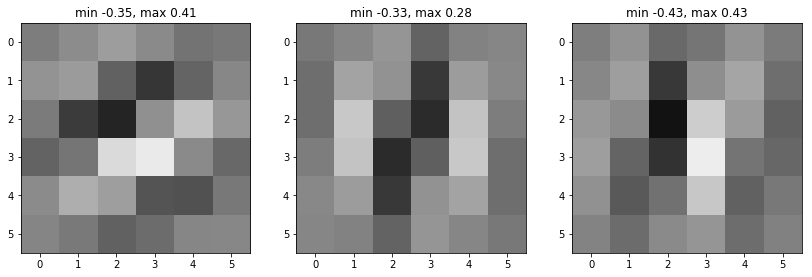

In [2]:
# Eq. (7) of the paper.
kernel_shape = (6,6)
kernelsize = np.prod(np.asarray(kernel_shape))

k1_kernel = ig.Gabor(frequency=2, phase=np.pi/3, xdensity=kernel_shape[1], ydensity=kernel_shape[0], size=0.5, orientation=np.pi/6)()
# k1e_kernel = ig.Gabor(frequency=2, phase=np.pi/3, xdensity=kernel_shape[1], ydensity=kernel_shape[0], size=0.5, orientation=np.pi/6+np.pi)()

# I didn't make excitatory and suppressive vertical.
# non-vertical seems to make the difference between eigenvalues for subtracting STA vs. not subtracting bigger.
k2_kernel = ig.Gabor(frequency=2, phase=np.pi, xdensity=kernel_shape[1], ydensity=kernel_shape[0], size=0.5, orientation=np.pi/6+np.pi/4)()
k3_kernel = ig.Gabor(frequency=2, phase=np.pi/2, xdensity=kernel_shape[1], ydensity=kernel_shape[0], size=0.5, orientation=np.pi/6+np.pi/4)()

kernels_all_original_shape = np.array([k1_kernel,k2_kernel,k3_kernel])
kernels_all = kernels_all_original_shape.reshape(3, -1)

def show_kernels():
    plt.close('all')
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    for (ax, kernel_this) in zip(axes, kernels_all):
        ax.imshow(kernel_this.reshape(kernel_shape), vmin=-0.5, vmax=0.5, cmap='gray')
        ax.set_title('min {:.2f}, max {:.2f}'.format(kernel_this.min(),
                                                     kernel_this.max()))
show_kernels()

In [3]:
# ok. let's generate some white input.
rng_state = np.random.RandomState(seed=0)
stim_in = rng_state.randn(2000000, kernelsize)

In [4]:
a = np.arange(-5, 10.0)
print(a, np.clip(a, 0, np.inf))

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.] [ 0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


In [5]:
def generate_eq7_output(stim_in_this, kernel_to_recover):
    # implement Eq. (7)
    # this should be N x 3.
    stim_out_linear = np.matmul(stim_in_this, kernel_to_recover.T)
    k1_response, k2_response, k3_response = stim_out_linear.T
    k1_response = np.square(np.clip(k1_response, 0, np.inf))
    k2_response = np.square(k2_response)
    k3_response = np.square(k3_response)
    
    return sigmoid(2*(1+k1_response)/(1+k2_response+0.4*k3_response))
    
    # change to this to generate different results when subtracting sta or not.
#     return sigmoid(2*k1_response+0.6*k2_response+0.4*k3_response)
    

In [6]:
def _get_kernels(vector_relevant_list, vector_irrelevant_list, project_sta):
      # get kernels.
    if not project_sta:
        # then excitatory is first one, suppresive are last two.
        relevant_e = vector_relevant_list[0, 0 ,0]
        relevant_i1 = vector_relevant_list[0, -2, 0]
        relevant_i2 = vector_relevant_list[0, -1, 0]
        # if you change `vector_irrelevant_list` to `vector_relevant_list`.
        # then _check_orthogonal will give large numbers.
        irrelevant_all = vector_irrelevant_list[0, 1:-2, 0]
    else:
        # otherwise, STA is the last one.
        relevant_e = vector_relevant_list[0, -1 ,0]
        relevant_i1 = vector_relevant_list[0, -3, 0]
        relevant_i2 = vector_relevant_list[0, -2, 0]
        irrelevant_all = vector_irrelevant_list[0, :-3, 0]
        



    relevant_e_flat = norm_vector(relevant_e.ravel())
    relevant_i1_flat = norm_vector(relevant_i1.ravel())
    relevant_i2_flat = norm_vector(relevant_i2.ravel())
    irrelevant_all = np.asarray([norm_vector(x.ravel()) for x in irrelevant_all])
    
    
    
    # I always present them in the order of e, i1, i2.
    relevant_all = np.asarray([relevant_e_flat, relevant_i1_flat, relevant_i2_flat])
    
    return relevant_all, irrelevant_all

def _check_orthogonal(relevant_all, irrelevant_all):
    result = relevant_all @ irrelevant_all.T
    assert abs(result).max() < 1e-6
    
def _check_projection(relevant_all, kernels_this):
    # see <https://en.wikipedia.org/wiki/Projection_(linear_algebra)>
    project_matrix = relevant_all.T@inv(relevant_all@relevant_all.T)@relevant_all
    kernels_this_projected = (project_matrix@kernels_this.T).T
    assert kernels_this_projected.shape == kernels_this.shape
    # check norm
    cos_values = np.asarray([cos_between(v1,v2) for v1, v2 in zip(kernels_this, kernels_this_projected)])
    # it's not very reliable.
    #
    print(cos_values)
    # this it not very stable. just increase tolerance
    assert np.allclose(cos_values, 1, atol=0.05)
    
    return kernels_this_projected

def _plot_recons(ax, refs, recons, line_names):
    line_style_list = ('--', '-', ':')
    
    assert len(line_names) == len(refs) == len(recons) <= len(line_style_list)
    for line_idx, (ref_this, recon_this, line_name) in enumerate(zip(refs, recons, line_names)):
        line_style_this = line_style_list[line_idx]
        ax.plot(ref_this, linestyle=line_style_this, color='r', alpha=0.5, label=f'{line_name} ref')
        ax.plot(recon_this, linestyle=line_style_this, color='b', alpha=0.5, label=f'{line_name} recon')
    ax.legend()

def _plot_pair(axes, ref, recon, line_name, vmin, vmax):
    axes[0].imshow(ref.reshape(kernel_shape), vmin=vmin, vmax=vmax, cmap='gray')
    axes[1].imshow(recon.reshape(kernel_shape), vmin=vmin, vmax=vmax, cmap='gray')
    axes[0].set_title(f'{line_name} ref')
    axes[1].set_title(f'{line_name} recon')
    
# iterate over 4 ways of doing STC.
def check_data_stc(stim_in_this, kernels_this, introduce_corr=False, seed=0):
    rng_state.seed(0)
    
    if introduce_corr:
        transform_matrix = test_util.generate_correlation_matrix(kernelsize, 0)
        assert matrix_rank(transform_matrix) == kernelsize
        stim_in_this = np.matmul(stim_in_this, transform_matrix)
        svd_cov = svd(preprocessing.cov_matrix(stim_in_this))
    else:
        svd_cov = None
    
    data_out = generate_eq7_output(stim_in_this, kernels_this)
    data_out_spike = (rng_state.rand(*data_out.shape) < data_out).astype(np.float64)
    print(data_out_spike.mean())
    for use_spike in (True, False):
        if use_spike:
            data_out_this = data_out_spike[:,np.newaxis]
        else:
            data_out_this = data_out[:,np.newaxis]
        eig_dict = dict()
        for (project_sta, subtract_sta) in product((True, False), (True, False)):
            (vector_original_list, eig_list,
             vector_relevant_list, vector_irrelevant_list) = rtc.rtc(stim_in_this,
                                                                     data_out_this,
                                                                     correction=introduce_corr,
                                                                     svd_of_cov_matrix=svd_cov,
                                                                     project_out_rta=project_sta,
                                                                     subtract_rta=subtract_sta)
            assert vector_original_list.shape == (1, kernelsize, kernelsize)
            assert eig_list.shape == (1, kernelsize)
            assert vector_relevant_list.shape == (1, kernelsize, kernelsize)
            assert vector_irrelevant_list.shape == (1, kernelsize, kernelsize)

            
            if not introduce_corr:
                assert np.array_equal(vector_original_list, vector_relevant_list)
                assert np.array_equal(vector_original_list, vector_irrelevant_list)            
            
            # collect eigs
            eig_dict[(project_sta, subtract_sta)] = eig_list[0]
            
            
            vector_relevant_list = preprocessing.reshape_kernel(vector_relevant_list,
                                                                kernel_shape, 1, 1, True)
            vector_irrelevant_list = preprocessing.reshape_kernel(vector_irrelevant_list,
                                                                 kernel_shape, 1, 1, True)
            #print(vector_relevant_list.shape)
            
#           
            relevant_all, irrelevant_all = _get_kernels(vector_relevant_list,
                                                        vector_irrelevant_list, project_sta)
            _check_orthogonal(relevant_all, irrelevant_all)
            
            # check projections
            projected_kernels = _check_projection(relevant_all, kernels_this)
            # plot pairs.
            
            
            # first, check 
            

            plt.close('all')
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            plt.suptitle('use {}, project rta {}, subtract rta {}'.format('spike' if use_spike else 'rate',
                                                                          project_sta, subtract_sta))
            # plot eigenvalues
            axes[0].scatter(np.arange(kernelsize)+1, eig_list[0])
            _plot_recons(axes[1], kernels_this[0:1], projected_kernels[0:1], ('e',))
            _plot_recons(axes[2], kernels_this[1:2], projected_kernels[1:2], ('i1',))
            _plot_recons(axes[3], kernels_this[2:3], projected_kernels[2:3], ('i2',))
            plt.show()
            
            
            # plot all three kernels, in pairs.
            plt.close('all')
            fig, axes = plt.subplots(1, 6, figsize=(20, 5))
            # check best way to show them.
            vmin = min(norm_vector(kernels_this[0]).min(), norm_vector(kernels_this[1]).min(),
                       norm_vector(kernels_this[2]).min(), relevant_all.min())
            vmax = min(norm_vector(kernels_this[0]).max(), norm_vector(kernels_this[1]).max(),
                       norm_vector(kernels_this[2]).max(), relevant_all.max())
            _plot_pair(axes[:2], norm_vector(kernels_this[0]), relevant_all[0], 'e', vmin, vmax)
            _plot_pair(axes[2:4], norm_vector(kernels_this[1]), relevant_all[1], 'i1', vmin, vmax)
            _plot_pair(axes[4:6], norm_vector(kernels_this[2]), relevant_all[2], 'i2', vmin, vmax)
            plt.show()
            
        # I should compare the eigenvalues for
        # when project rta is True, subtracting rta or not should give no difference.
        
        # when project rta is False, there should be some difference in relevant directions 
        # but little difference in irrelevant directions, for subtracting rta or not
        plt.close('all')
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        plt.suptitle('use {}, comparison of eigenvalues at different conditions'.format('spike' if use_spike else 'rate'))
        
        axes[0].scatter(np.arange(kernelsize)+1, eig_dict[True, True]-eig_dict[True, False])
        axes[0].set_title('when projecting sta out, subtract - no_subtract (should be all flat)')
        
        axes[1].scatter(np.arange(kernelsize)+1, eig_dict[False, True]-eig_dict[False, False])
        axes[1].set_title('when NOT projecting sta out, subtract - no_subtract (should be only changed at relevant directions if at all)')
        
        plt.show()
        
        

0.7893335
[ 0.99625862  0.9991745   0.99865529]


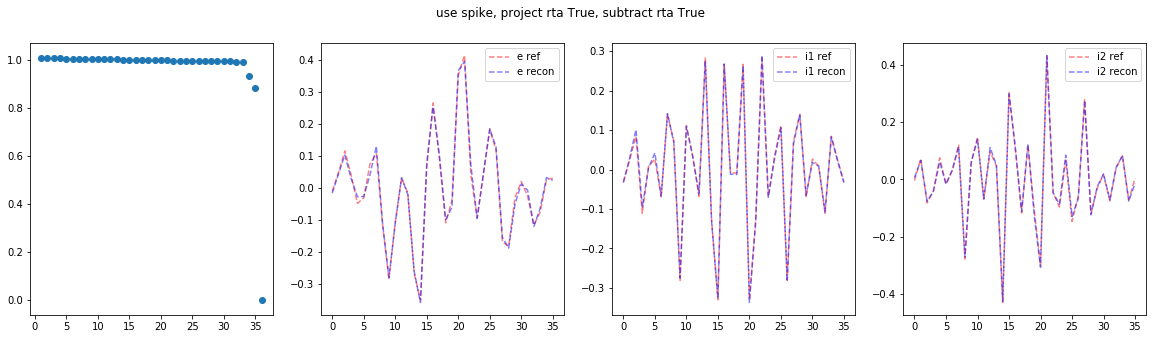

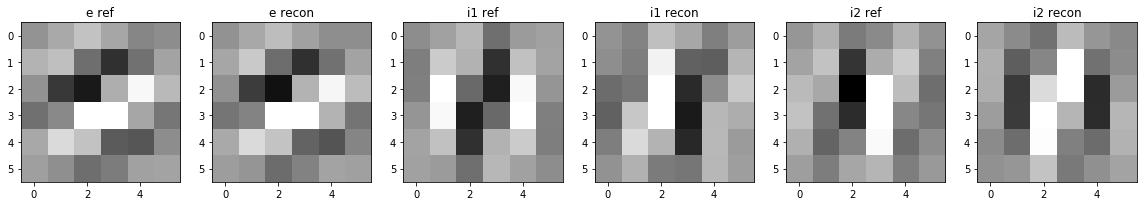

[ 0.99625862  0.9991745   0.99865529]


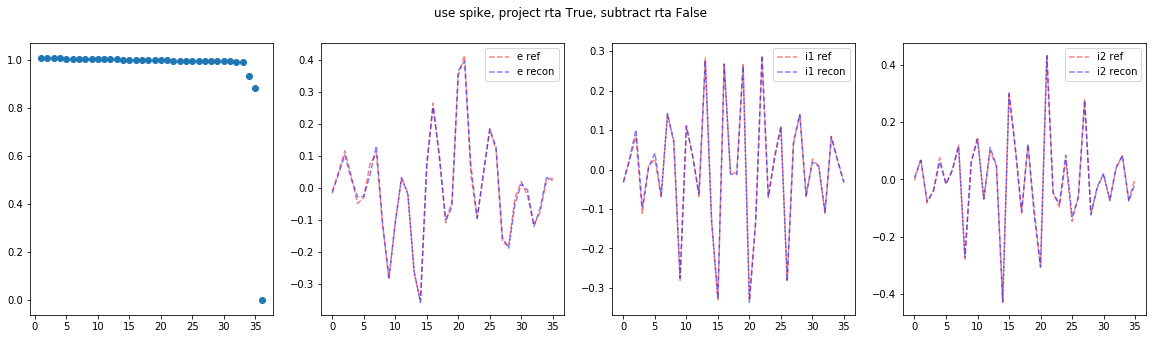

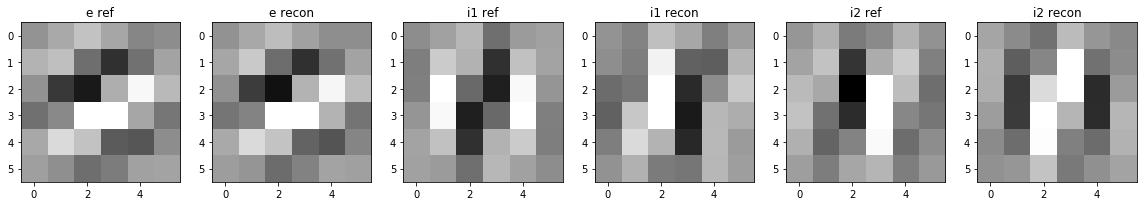

[ 0.99402999  0.9991922   0.99866528]


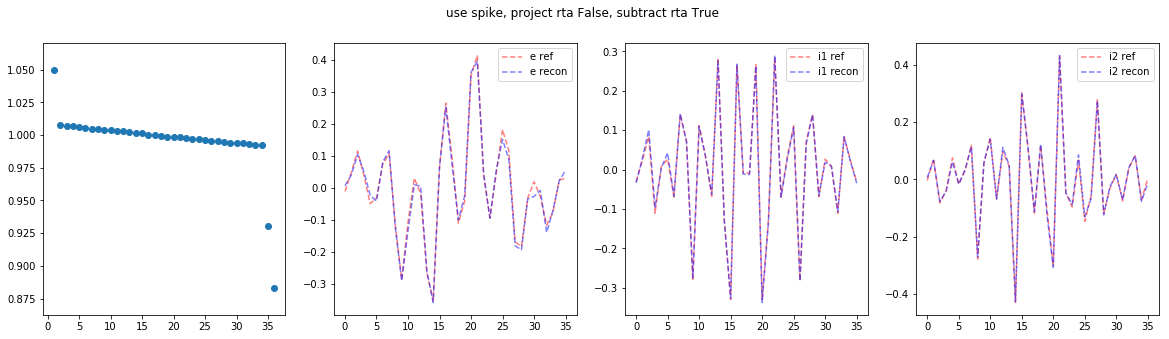

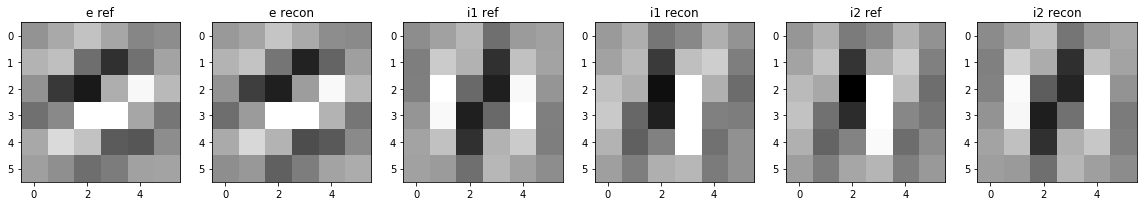

[ 0.99492272  0.99919088  0.99866494]


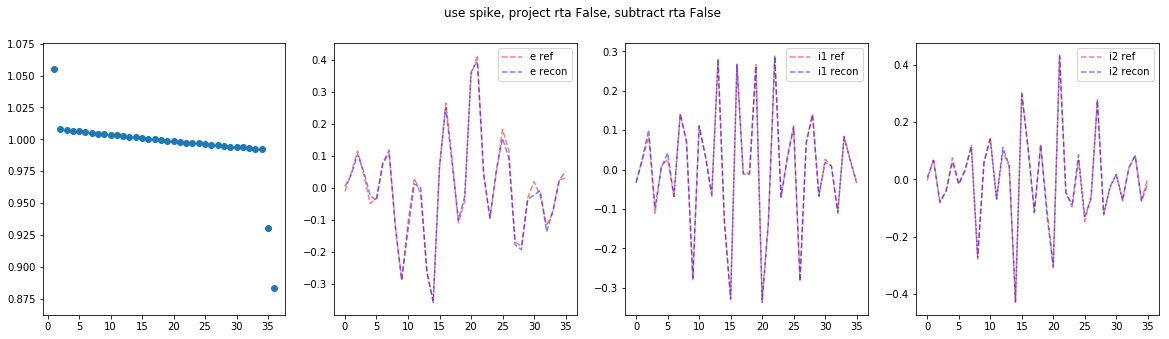

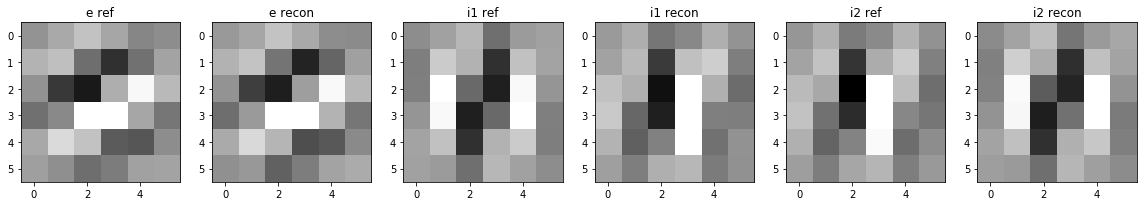

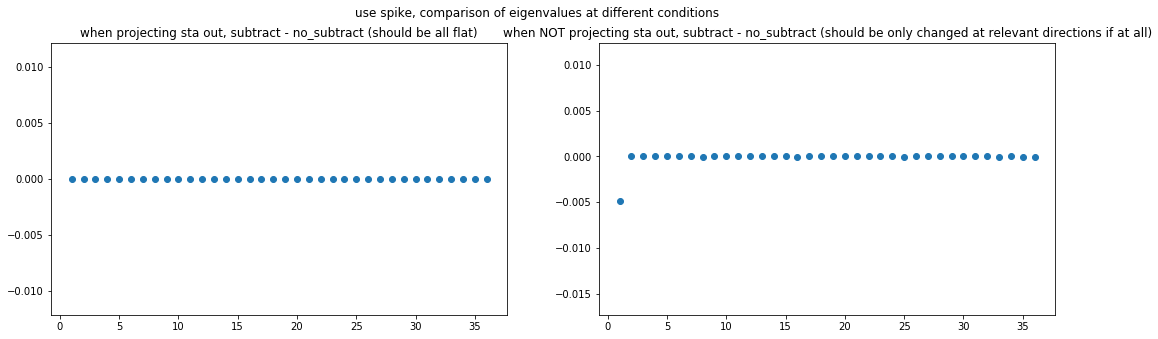

[ 0.99740152  0.99985927  0.99974955]


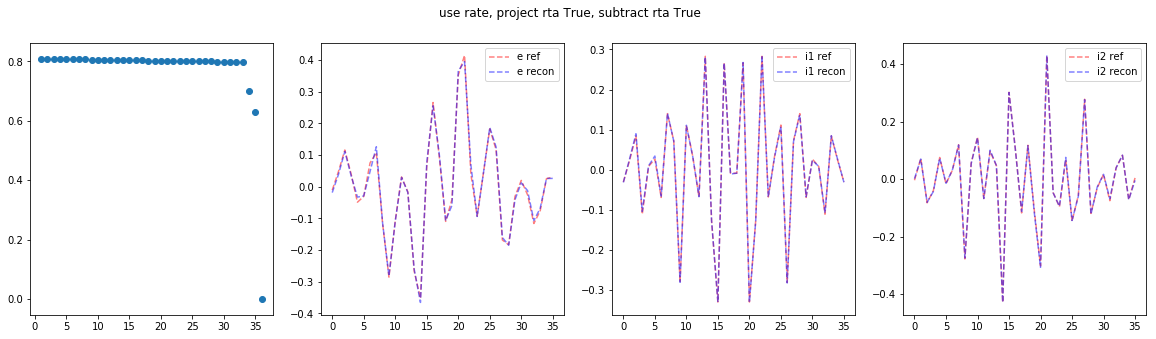

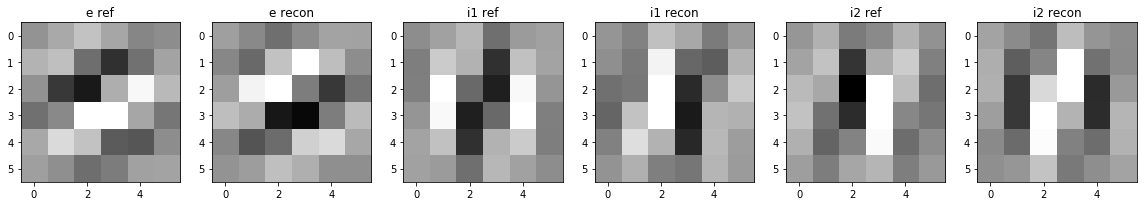

[ 0.99740152  0.99985927  0.99974955]


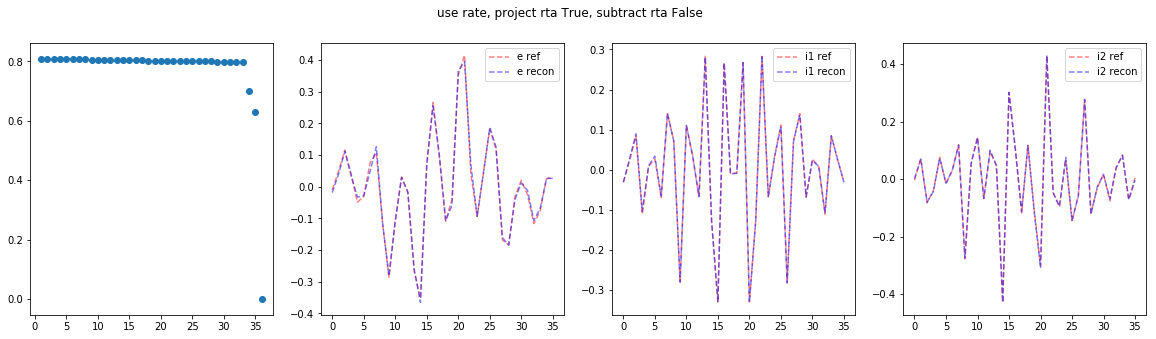

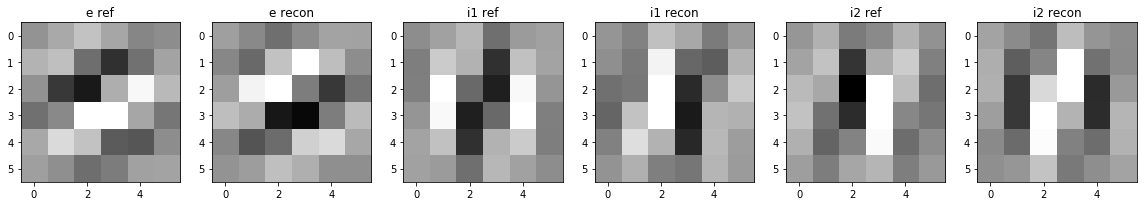

[ 0.99876285  0.99986175  0.99974901]


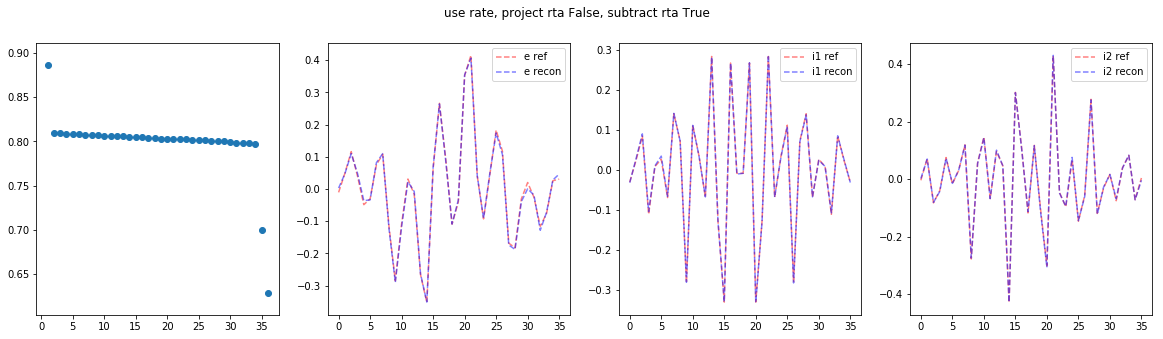

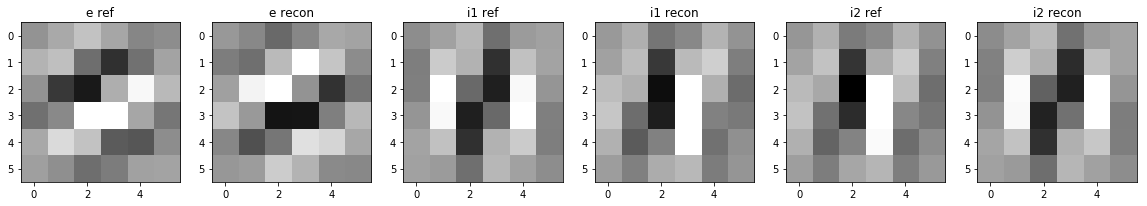

[ 0.99902468  0.99986155  0.99974922]


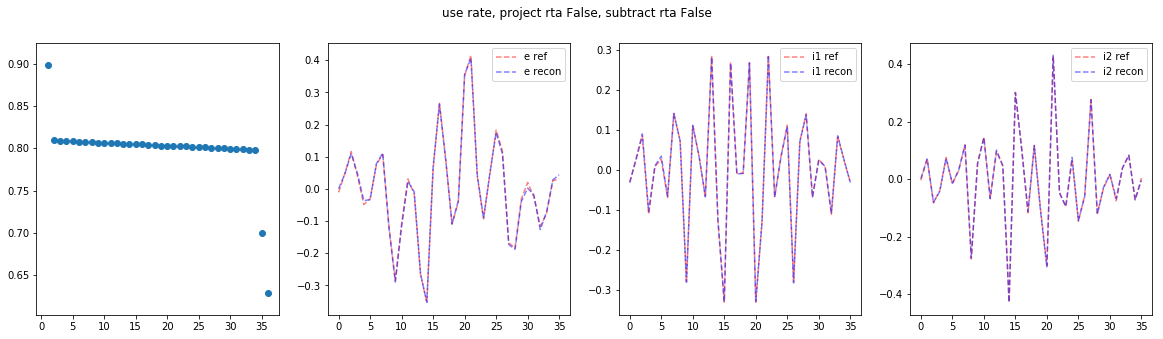

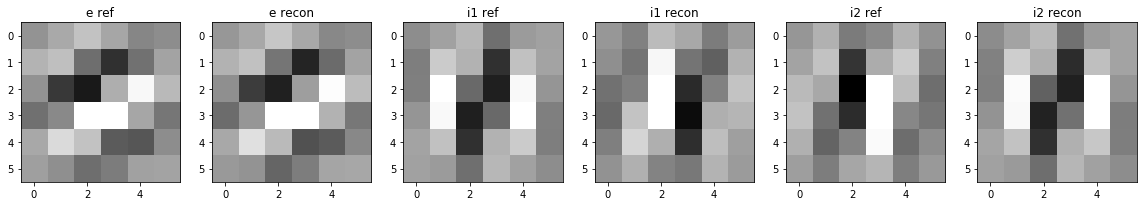

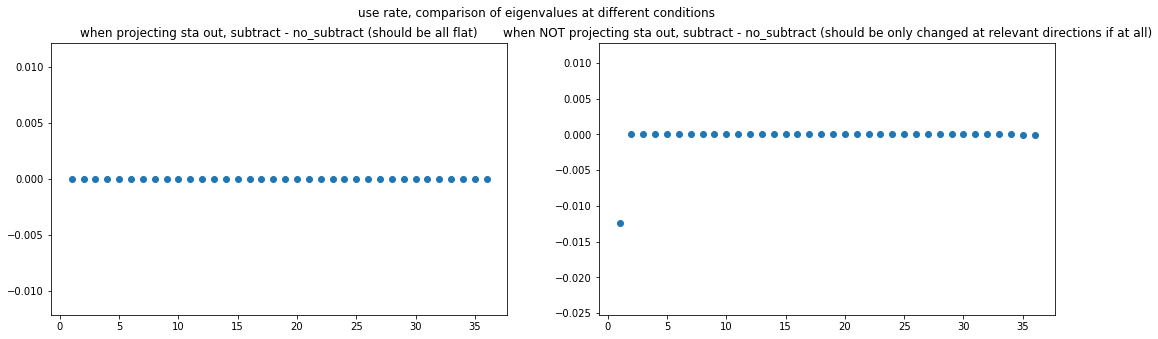

In [7]:
check_data_stc(stim_in, kernels_all)

0.7063685
[ 0.9879718   0.98526928  0.99608289]


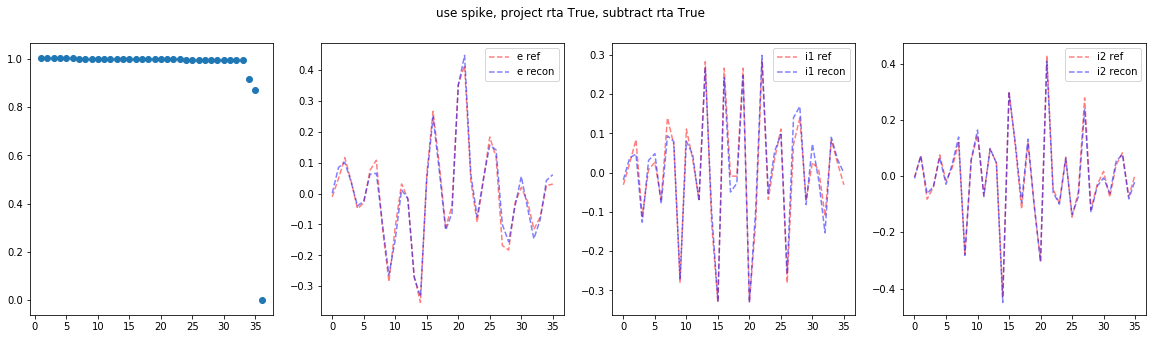

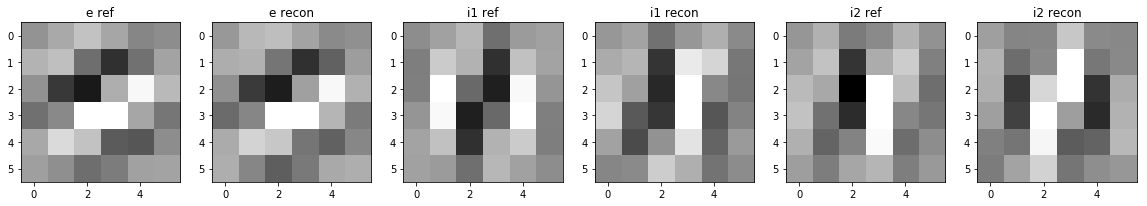

[ 0.9879718   0.98526928  0.99608289]


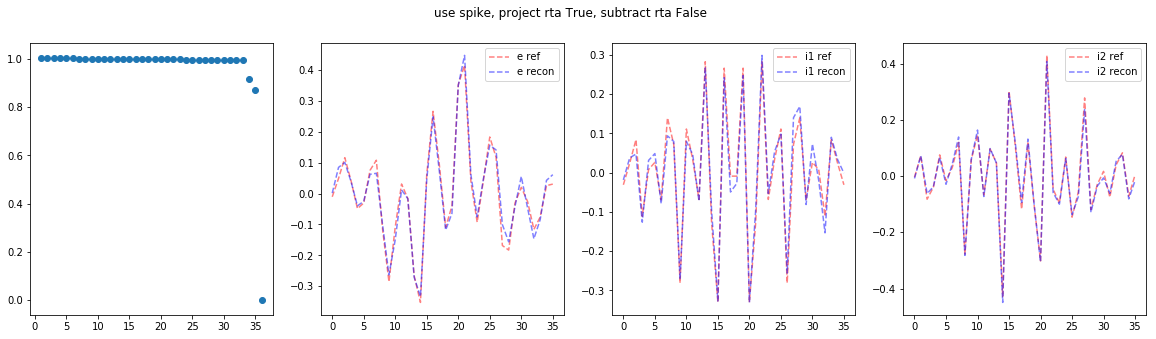

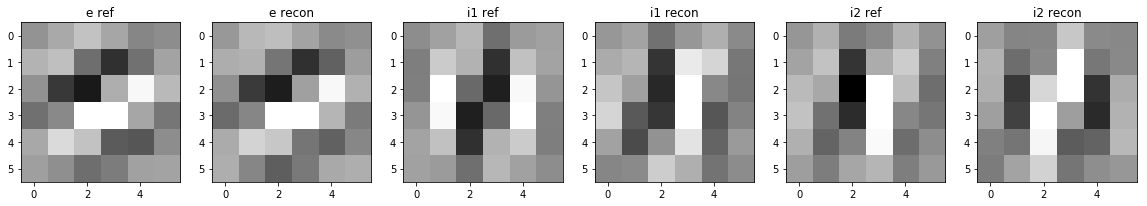

[ 0.98753473  0.98415754  0.99435403]


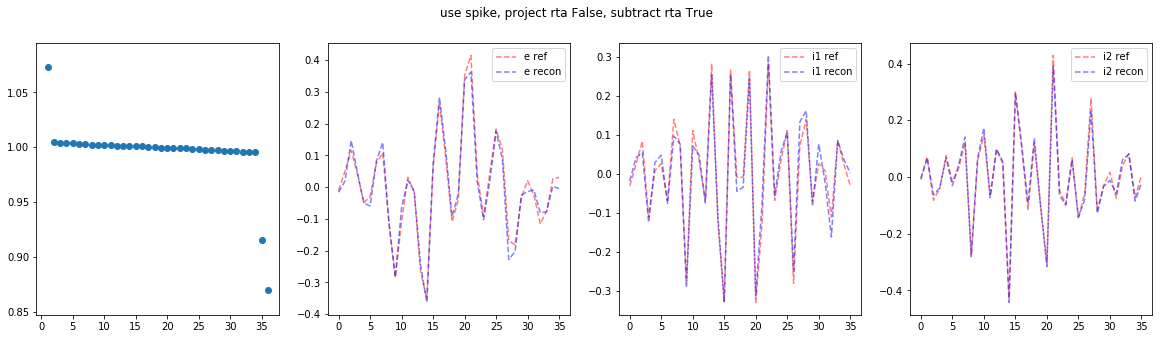

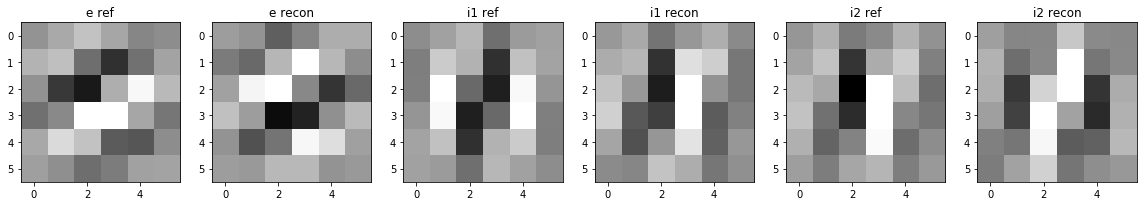

[ 0.99578972  0.98417217  0.99470114]


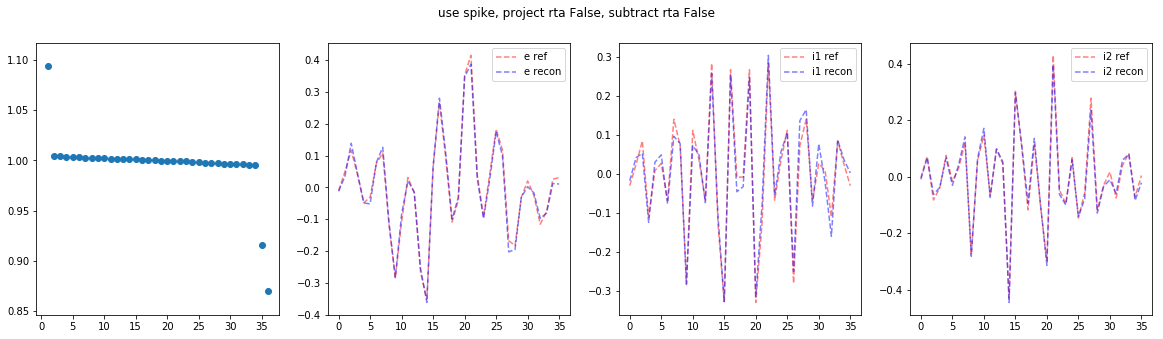

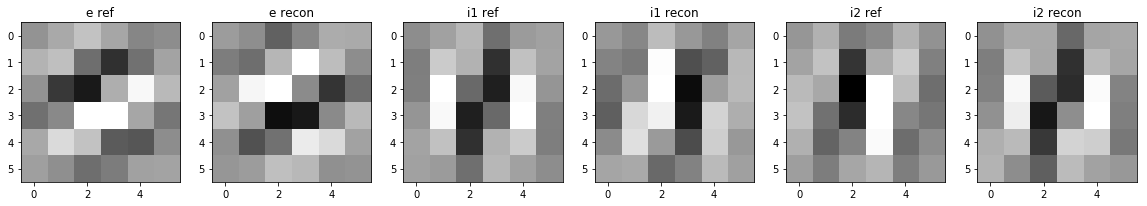

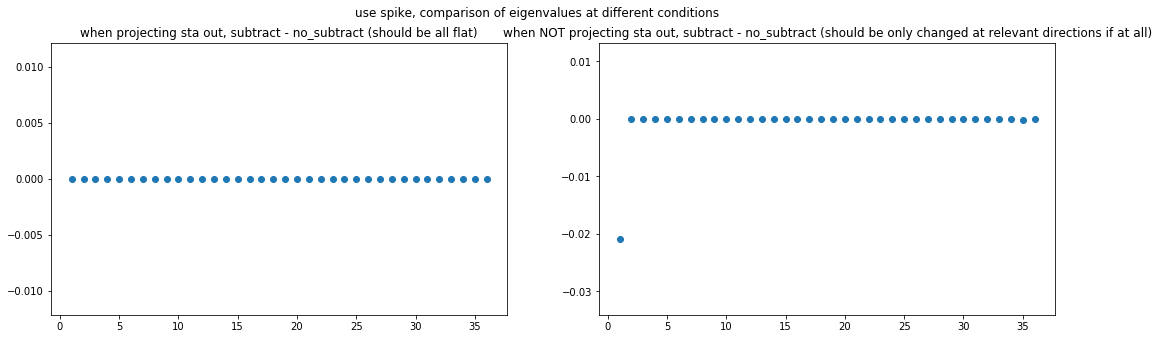

[ 0.99426125  0.99957649  0.99973329]


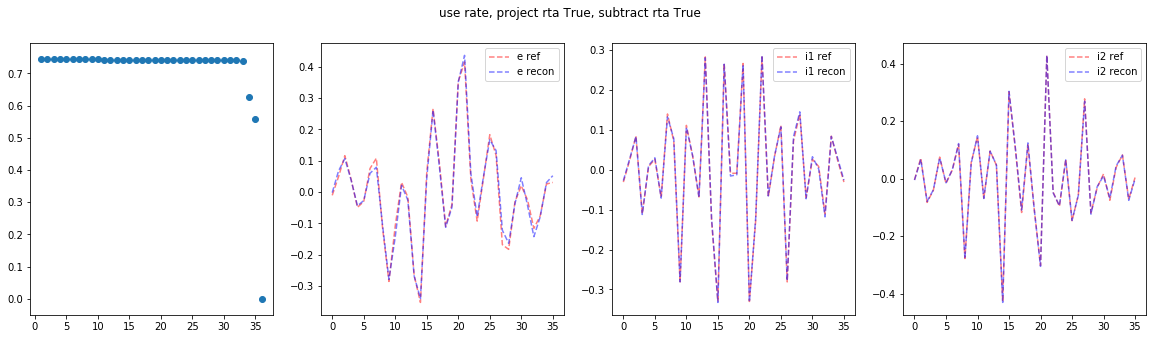

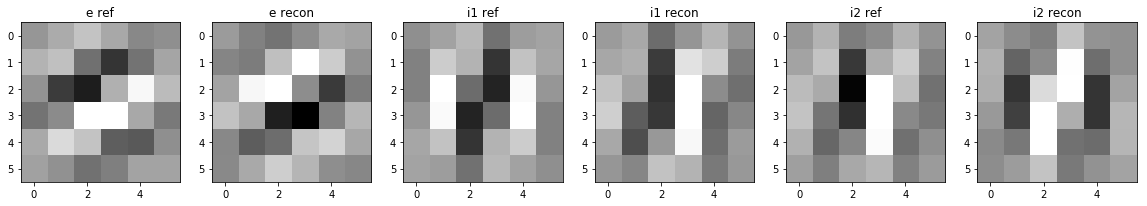

[ 0.99426125  0.99957649  0.99973329]


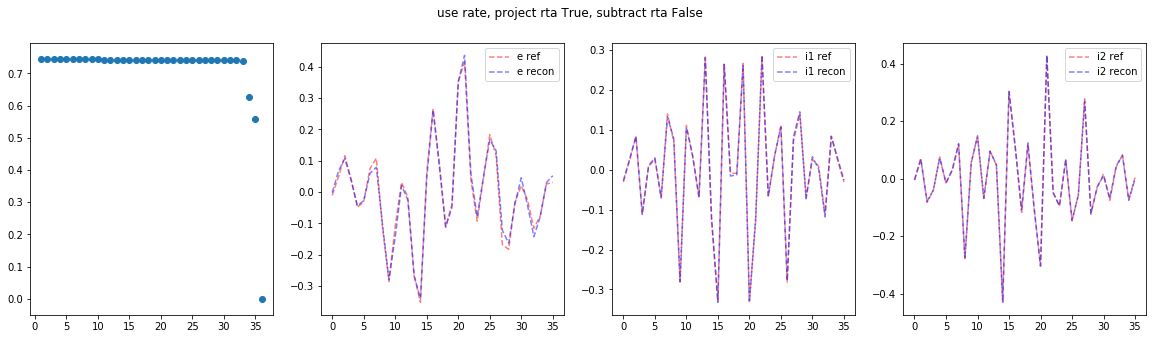

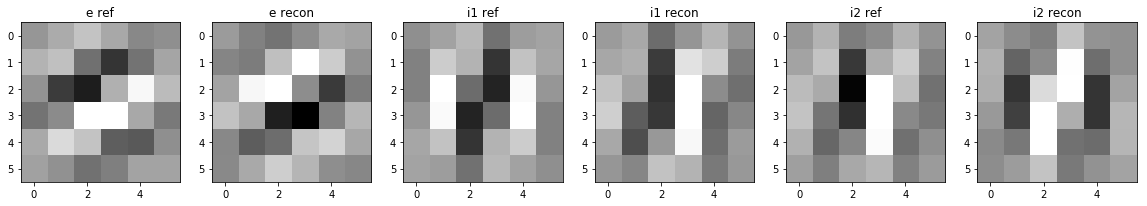

[ 0.99960592  0.99955457  0.99960654]


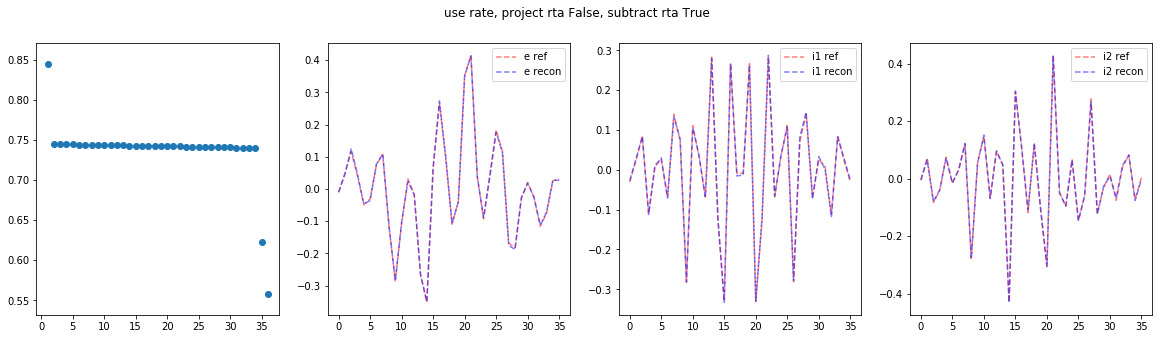

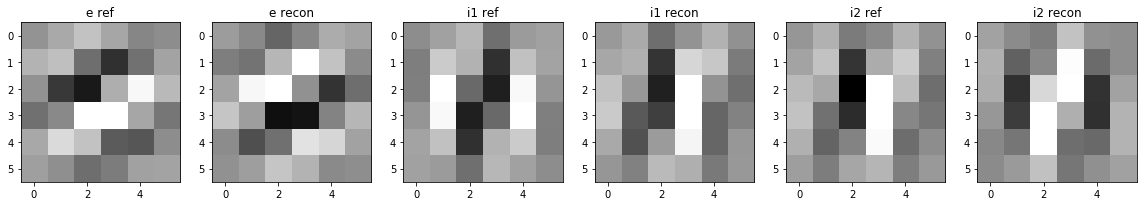

[ 0.99973748  0.99956201  0.99964367]


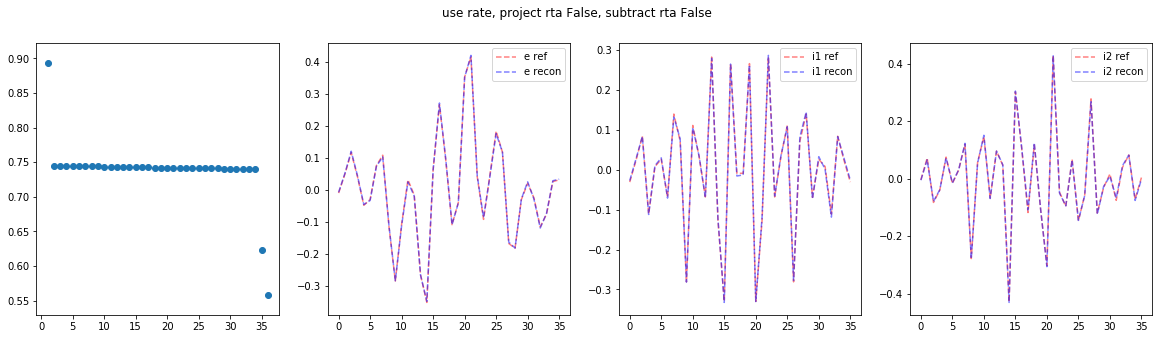

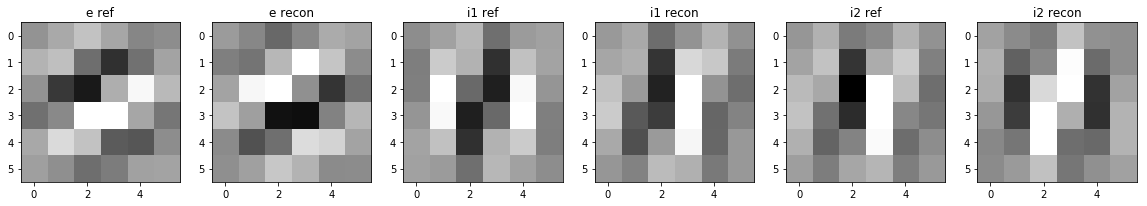

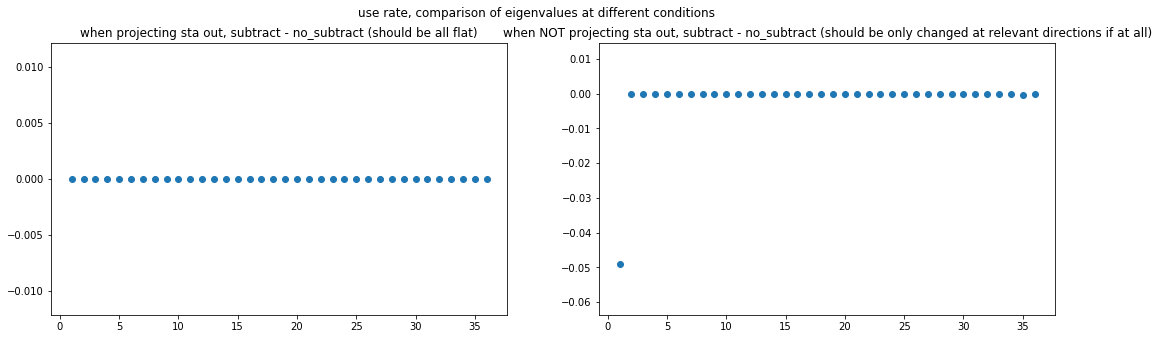

In [8]:
check_data_stc(stim_in, kernels_all, introduce_corr=True)